# How to use `scivision`

In this notebook, we will:

1. Demonstrate using the scivision [Python API](https://scivision.readthedocs.io/en/latest/api.html) to load several pretrained image classification models
2. Use the scivision catalog to find a matching dataset, which the model can be run on
3. Run the model on the data, performing simple model inference
4. Use the scivision catalog to find another model that can be run on the same dataset

First let's import some things from scivision: `default_catalog` is a scivision **catalog** that will let us discover models and datasets, and `load_pretrained_model` provides a convenient way to load and run a model.

In [1]:
from scivision import default_catalog, load_pretrained_model

## Inspecting our model in the scivision catalog

A scivision catalog is a collection of **models** and **datasources**.

For this example, we want to find datasources compatible with the model catalog entry "image-classifiers".  But first, let's use the catalog to retrive the "image-classifiers" repository url and take a look at the data contained in the *default catalog* (the built-in catalog, distributed as part of scivision) and see how this is structured.

In [2]:
# Get the model repo url
model_name = "butterfly_model" # add the name of the added model
models_catalog = default_catalog.models.to_dataframe()
model_repo = models_catalog[models_catalog.name == model_name].url.item()
model_repo # Why not paste the repo lihttps://github.com/NHomer-Edi/butterfly_classification_model_finishingnk into your browser and see how it looks?

FlexibleUrl('https://github.com/NHomer-Edi/butterfly_classification_model_finishing', scheme='https', host='github.com', tld='com', host_type='domain', path='/NHomer-Edi/butterfly_classification_model_finishing')

In [3]:
# Inspecting model entry and its metadata in the default catalog
models_catalog[models_catalog.name == model_name]

,name,description,tasks,url,pkg_url,format,pretrained,labels_required,institution,tags
13,butterfly_model,None,"(TaskEnum.classificiation,)",https://github.com/NHomer-Edi/butterfly_classi...,git+https://github.com/NHomer-Edi/butterfly_cl...,image,True,False,"(ATI,)","(buttefly, biology)"


In [4]:
#!pip uninstall butterfly_classification_model -y

## Loading the model

Some model entries in the scivision catalog contain a single loadable model. Here, let's load the "image-classifiers" entry, which contains each of the models in the [image-classifiers](https://pypi.org/project/image-classifiers/) package. We can do this with the `load_pretrained_model` function. We'll load 2 models (`resnet18` and `densenet121`).

Note: the "model" arg is not mandatory and will have a default value for any model catalog entries that have more than one model - for model catalog entries with a single model, this need not be set:

In [ ]:
# Note: when loading this model repo for the first time you'll need to add the allow_install=True flag
butterfly_model = "efficientNetB3" # name given to the butterfly model

butterfly_model = load_pretrained_model(model_repo, model=butterfly_model, allow_install=True)
#densenet_model = load_pretrained_model(model_repo, model='densenet121')

In [6]:
# let's explore one of the model objects
butterfly_model

scivision.PretrainedModel( 
  module='butterfly_classification_model', 
  model='efficientNetB3', 
  source='https://github.com/NHomer-Edi/butterfly_classification_model_finishing' 
  pipe='DataPipe(input=<Parameter "X: numpy.ndarray">, output=<Parameter "image: numpy.ndarray">)' 
)

Later, we'll use these models to make predictions on image data found in the scivision catalog.

## Load the dataset

Now let's load the dataset using the scivision python API, specifically the [load_dataset](https://scivision.readthedocs.io/en/latest/api.html#scivision.io.reader.load_dataset) function, which takes as input the url of the data repository (structured as per [this template](https://scivision.readthedocs.io/en/latest/data_repository_template.html)), which we can get from the target datasource:

In [7]:
from scivision import load_dataset

In [8]:
name = "data-007" # insert dataset name once it is added to the catalog

target_datasource = default_catalog.datasources.to_dataframe()
target_datasource = target_datasource.loc[target_datasource['name'] == name]

target_datasource

,name,description,tasks,labels_provided,domains,url,format,institution,tags
7,data-007,Dataset of butterflies,(TaskEnum.classificiation),True,"(computer-vision, ecology)",https://github.com/devinamhn/butterfly_repo,image,"(Alan Turing,)","(ecology, environmental-science)"


In [9]:
data_url = target_datasource['url'].item()

In [10]:
data_url

FlexibleUrl('https://github.com/devinamhn/butterfly_repo', scheme='https', host='github.com', tld='com', host_type='domain', path='/devinamhn/butterfly_repo')

The returned data config object of the`load_dataset` function is an "intake catalog". You can read our [documentation](https://scivision.readthedocs.io/en/latest/data_repository_template.html#data-config-file) to understand this better, but for now, let's inspect this config:

In [11]:
data_config = load_dataset(data_url)
data_config

data:
  args:
    path: https://raw.githubusercontent.com/devinamhn/butterfly_repo/main/.scivision/data.yml
  description: ''
  driver: intake.catalog.local.YAMLFileCatalog
  metadata: {}


In [12]:
data_config.walk()

{'butterfly': name: butterfly
 container: xarray
 plugin: ['xarray_image']
 driver: ['xarray_image']
 description: Images of butterflies ATI Workshop
 direct_access: forbid
 user_parameters: []
 metadata: 
 args: 
   urlpath: ['zip://*.jpg::https://zenodo.org/record/7113477/files/Butterflies.zip?download=1']}

Clicking the `path` link to the location of this data config file online (in the dataset repo) reveals that there is one data source called `test_image`, and that the `intake_xarray.image.ImageSource` "intake driver" is being used. We can retrive the test image data in an image format which the model will accept, like so:

In [13]:
test_image = data_config.butterfly().to_dask() # The xarray.DataArray is one format accepted by the our models
test_image

,Array,Chunk
Bytes,1.30 GiB,147.00 kiB
Shape,"(9285, 224, 224, 3)","(1, 224, 224, 3)"
Count,1 Graph Layer,9285 Chunks
Type,uint8,numpy.ndarray


Let's take a look at the image with `matplotlib`:

In [14]:
import matplotlib.pyplot as plt

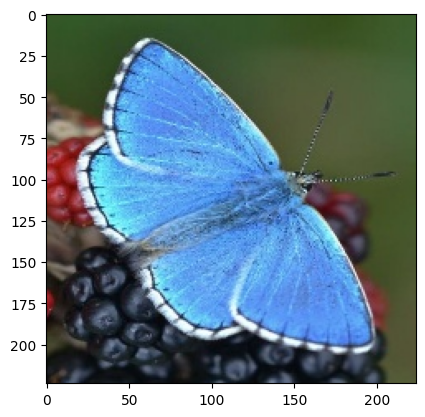

In [19]:
id = 10
plt.imshow(test_image[id])

## Model predictions

Now let's use the loaded model on the test image data we found in the via catalog.

In [20]:
butterfly_model.predict(test_image[id])

1/1 [==============================] - 0s 65ms/step


'ADONIS'

As you can see, the models have given predictions for the test image, with a confidence score. Check out the code in the [model repo](https://github.com/alan-turing-institute/scivision_classifier) to see how this was determined!